In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline  
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

df = pd.read_csv("C:/Users/vimba/OneDrive/Documents/School 2025/Spring 2025/ML/ML_Project/raw_database.csv", low_memory=False)

In [298]:
print(df['Species Name'].isna().sum()) 
df = df.dropna(subset=['Species Name'])
print(df['Species Name'].isna().sum()) 
#df['Species Name'].value_counts()
top50 = df['Species Name'].value_counts().head(50)
print(top50)

80
0
Species Name
UNKNOWN MEDIUM BIRD      38531
UNKNOWN SMALL BIRD       32981
MOURNING DOVE             7653
GULL                      6580
UNKNOWN BIRD              6400
KILLDEER                  4562
AMERICAN KESTREL          4476
BARN SWALLOW              4215
HORNED LARK               3952
EUROPEAN STARLING         3915
SPARROW                   3152
ROCK PIGEON               2893
UNKNOWN LARGE BIRD        2789
RED-TAILED HAWK           2254
EASTERN MEADOWLARK        1829
CANADA GOOSE              1574
RING-BILLED GULL          1531
CLIFF SWALLOW             1485
HAWK                      1313
BLACKBIRD                 1281
HERRING GULL              1199
BARN OWL                  1118
WESTERN MEADOWLARK        1072
SWALLOW                   1053
DOVE                      1041
WHITE-TAILED DEER         1021
AMERICAN ROBIN             957
PACIFIC GOLDEN-PLOVER      909
MALLARD                    877
PERCHING BIRDS             867
DUCK                       814
MICROBAT             

In [299]:
grp_mapping = {
    "BARN SWALLOW": "Swallows & Swifts",
    "CLIFF SWALLOW": "Swallows & Swifts",
    "TREE SWALLOW": "Swallows & Swifts",
    "BANK SWALLOW": "Swallows & Swifts",
    "SWALLOW": "Swallows & Swifts",
    "CHIMNEY SWIFT": "Swallows & Swifts",

    "GULL": "Gulls & Water Birds",
    "RING-BILLED GULL": "Gulls & Water Birds",
    "HERRING GULL": "Gulls & Water Birds",
    "LAUGHING GULL": "Gulls & Water Birds",

    "RED-TAILED HAWK": "Raptors",
    "AMERICAN KESTREL": "Raptors",
    "HAWK": "Raptors",
    "TURKEY VULTURE": "Raptors",
    "OSPREY": "Raptors",
    "PEREGRINE FALCON": "Raptors",

    "MOURNING DOVE": "Pigeons & Doves",
    "ROCK PIGEON": "Pigeons & Doves",
    "DOVE": "Pigeons & Doves",

    "SPARROW": "Small Land Birds",
    "PERCHING BIRDS": "Small Land Birds",
    "BLACKBIRD": "Small Land Birds",
    "RED-WINGED BLACKBIRD": "Small Land Birds",
    "SAVANNAH SPARROW": "Small Land Birds",
    "EASTERN MEADOWLARK": "Small Land Birds",
    "WESTERN MEADOWLARK": "Small Land Birds",
    "MEADOWLARK": "Small Land Birds",
    "AMERICAN ROBIN": "Small Land Birds",
    "AMERICAN CROW": "Small Land Birds",
    "COMMON NIGHTHAWK": "Small Land Birds",

    "MALLARD": "Gulls & Water Birds",
    "DUCK": "Gulls & Water Birds",
    "EGRET": "Gulls & Water Birds",
    "CATTLE EGRET": "Gulls & Water Birds",
    "GREAT BLUE HERON": "Gulls & Water Birds",

    "WHITE-TAILED DEER": "Mammals",
    "COYOTE": "Mammals",}

def assign_group(species):
    if species in grp_mapping:
        return grp_mapping[species]
    elif species == "UNKNOWN BIRD OR BAT" or species == "UNKNOWN MAMMAL":
        return "Mammals"  
    elif isinstance(species, str) and species.startswith("UNKNOWN"):
        return species  
    else:
        return "Rare Animals"

df["Species Group"] = df["Species Name"].apply(assign_group)
print(df["Species Group"].value_counts())

Species Group
UNKNOWN MEDIUM BIRD           38531
Rare Animals                  38184
UNKNOWN SMALL BIRD            32981
Gulls & Water Birds           12535
Pigeons & Doves               11587
Small Land Birds              11480
Raptors                        9472
Swallows & Swifts              8451
UNKNOWN BIRD                   6400
UNKNOWN LARGE BIRD             2789
Mammals                        1589
UNKNOWN TERRESTRIAL MAMMAL       25
Name: count, dtype: int64


The primary target is the species name column so I removed all all its Nan values. 

In [300]:
def updated_species_group(group):
    if group in ["Mammals", "UNKNOWN TERRESTRIAL MAMMAL"]:
        return "Rare Animals"
    elif group in ["UNKNOWN BIRD", "UNKNOWN LARGE BIRD"]:
        return "Unknown Birds"
    else:
        return group

df["Species Group"] = df["Species Group"].apply(updated_species_group)
print(df["Species Group"].value_counts())


Species Group
Rare Animals           39798
UNKNOWN MEDIUM BIRD    38531
UNKNOWN SMALL BIRD     32981
Gulls & Water Birds    12535
Pigeons & Doves        11587
Small Land Birds       11480
Raptors                 9472
Unknown Birds           9189
Swallows & Swifts       8451
Name: count, dtype: int64


After loading and taking care of species, I filled the missing catergorical variables with 'UNKNOWN' first and did more bucketing on certain variables. 

In [301]:
df['Flight Phase'] = df['Flight Phase'].fillna('UNKNOWN')
df['Engine Type'] = df['Engine Type'].fillna('UNKNOWN')
df['State'] = df['State'].fillna('UNKNOWN')

#print(df['Flight Phase'].value_counts(dropna=False))
#print(df['Engine Type'].value_counts(dropna=False))
#print(df['State'].value_counts(dropna=False))

region_map = {'AK': 'West', 'CA': 'West', 'CO': 'West', 'HI': 'West',
    'ID': 'West', 'MT': 'West', 'NV': 'West', 'OR': 'West',
    'UT': 'West', 'WA': 'West', 'WY': 'West',
    
    'IA': 'Midwest', 'IL': 'Midwest', 'IN': 'Midwest', 'KS': 'Midwest',
    'MI': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest',
    'ND': 'Midwest', 'OH': 'Midwest', 'SD': 'Midwest', 'WI': 'Midwest',
    
    'AL': 'Southeast', 'AR': 'Southeast', 'FL': 'Southeast', 'GA': 'Southeast',
    'KY': 'Southeast', 'LA': 'Southeast', 'MS': 'Southeast', 'NC': 'Southeast',
    'SC': 'Southeast', 'TN': 'Southeast', 'VA': 'Southeast', 'WV': 'Southeast',
    
    'CT': 'Northeast', 'DE': 'Northeast', 'MA': 'Northeast', 'MD': 'Northeast',
    'ME': 'Northeast', 'NH': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast',
    'PA': 'Northeast', 'RI': 'Northeast', 'VT': 'Northeast',
    'AZ': 'Southwest', 'NM': 'Southwest', 'OK': 'Southwest', 'TX': 'Southwest',
    'PR': 'Other', 'VI': 'Other', 'GU': 'Other', 'DC': 'Other', 'UNKNOWN': 'UNKNOWN'}

df['State'] = df['State'].map(region_map).fillna('Other') 

#df['Flight Phase'].value_counts()
#df['Engine Type'].value_counts() <---- I needed to see what the names were.

def cl_engine(val):
    val = str(val).strip().upper()
    if val in ['D', 'C', 'A', 'F']:
        return val
    elif val == 'UNKNOWN':
        return 'UNKNOWN'
    else:
        return 'OTHER'

df['Engine Type Cleaned'] = df['Engine Type'].apply(cl_engine)

def cl_phase(val):
    val = str(val).strip().upper()
    if val in ['APPROACH', 'CLIMB', 'EN ROUTE', 'DESCENT']:
        return val
    elif val == 'UNKNOWN':
        return 'UNKNOWN'
    else:
        return 'OTHER'

df['Flight Phase Cleaned'] = df['Flight Phase'].apply(cl_phase)

I then split the data and did the one-hot encoding... I prefer converting to a more readable format like dataframes. 

In [302]:
# I removed all the post strike information. The focus is on the target variable
# and the flight phase, post-strike information is irrelevant to us:
y = df['Species Group']
X = df[['Incident Month', 'Flight Phase Cleaned','Aircraft Mass', 'Engine Type Cleaned', 'State', 'Height', 'Speed']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [303]:
cat_feats = ['Flight Phase Cleaned', 'Engine Type Cleaned', 'State']
nu_feats = ['Aircraft Mass', 'Height', 'Speed', 'Incident Month']

nu_imputer = SimpleImputer(strategy='median')
X_train[nu_feats] = nu_imputer.fit_transform(X_train[nu_feats])
X_test[nu_feats] = nu_imputer.transform(X_test[nu_feats])

In [304]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_tr_enc = encoder.fit_transform(X_train[cat_feats])
X_te_enc = encoder.transform(X_test[cat_feats])

tr_enc_df = pd.DataFrame(X_tr_enc, columns = encoder.get_feature_names_out(cat_feats))
te_enc_df = pd.DataFrame(X_te_enc, columns = encoder.get_feature_names_out(cat_feats))

Xtr_final = pd.concat([X_train[nu_feats].reset_index(drop=True), tr_enc_df], axis=1)
Xte_final = pd.concat([X_test[nu_feats].reset_index(drop=True), te_enc_df], axis=1)

I applied Smote because the imbalance was too much. This will be used on Log Reg and SCV:

In [305]:
smote = SMOTE(random_state=42)
Xtr_bal, y_tr_bal = smote.fit_resample(Xtr_final, y_train)

The FIRST MODEL we tried was:
## LOGISTIC REGRESSION:

In [306]:
scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(Xtr_bal)
Xte_sc = scaler.transform(Xte_final)

log_params = {'penalty': ['l2'], 
             'C': [0.5, 1, 10],
             'solver': ['saga']}

log_gr = GridSearchCV(LogisticRegression(max_iter=1000, multi_class='multinomial'),
                      param_grid=log_params,
                      cv=3,
                      scoring='f1_macro',
                      n_jobs=-1, verbose=2)

log_gr.fit(Xtr_sc, y_tr_bal)

top_logr = log_gr.best_estimator_
y_pred_logr = top_logr.predict(Xte_sc)

print("Best Logistic Regression")
print(f"Best params: {log_gr.best_params_}")
print(classification_report(y_test, y_pred_logr))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\vimba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Logistic Regression
Best params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
                     precision    recall  f1-score   support

Gulls & Water Birds       0.17      0.35      0.22      2507
    Pigeons & Doves       0.22      0.40      0.28      2318
            Raptors       0.14      0.29      0.18      1894
       Rare Animals       0.50      0.15      0.23      7960
   Small Land Birds       0.09      0.01      0.01      2296
  Swallows & Swifts       0.08      0.21      0.12      1690
UNKNOWN MEDIUM BIRD       0.51      0.30      0.38      7706
 UNKNOWN SMALL BIRD       0.33      0.35      0.34      6596
      Unknown Birds       0.13      0.21      0.16      1838

           accuracy                           0.25     34805
          macro avg       0.24      0.25      0.21     34805
       weighted avg       0.34      0.25      0.26     34805



From the log loss score below, we can see the model is doing okay. Optimal would be 0 so it needs some amendments. 

In [307]:
print("Log Loss:", log_loss(y_test, log_gr.predict_proba(Xte_sc)))
print("Accuracy:", accuracy_score(y_test, y_pred_logr))

Log Loss: 1.953414901135884
Accuracy: 0.2548771728199971


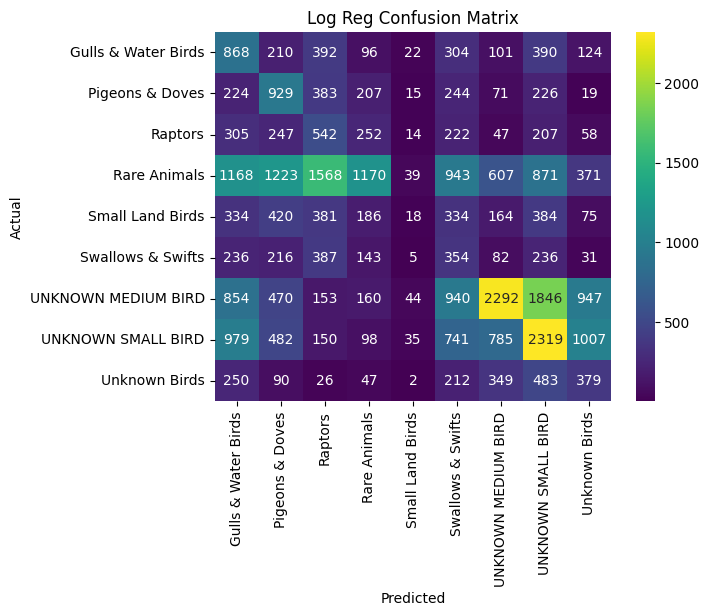

In [308]:
cm = confusion_matrix(y_test, y_pred_logr)
sns.heatmap(cm, cmap='viridis', annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Log Reg Confusion Matrix")
plt.show()

Now with Log Reg Feature Importance: From looking at the co-efficients for feature importance, we can see: Height is the most important predictor in this model, followed by state_unknown and flight phase unknown (So this shows some regional aspects are good predictors as well). 

In [309]:
ifeat_log = top_logr.coef_ 
imp = np.mean(np.abs(ifeat_log), axis=0)
imp_df = pd.DataFrame({"Feature": Xtr_final.columns, 
                       "Importance": imp}).sort_values(by="Importance", ascending=False)

print(imp_df)

                          Feature  Importance
1                          Height    0.388986
21                  State_UNKNOWN    0.342225
9    Flight Phase Cleaned_UNKNOWN    0.270620
15    Engine Type Cleaned_UNKNOWN    0.188159
4   Flight Phase Cleaned_APPROACH    0.178142
17                State_Northeast    0.140221
20                State_Southwest    0.114014
5      Flight Phase Cleaned_CLIMB    0.111846
0                   Aircraft Mass    0.105141
2                           Speed    0.104657
12          Engine Type Cleaned_D    0.099713
16                  State_Midwest    0.098666
10          Engine Type Cleaned_A    0.088008
7   Flight Phase Cleaned_EN ROUTE    0.078071
13          Engine Type Cleaned_F    0.076325
11          Engine Type Cleaned_C    0.072785
22                     State_West    0.071787
18                    State_Other    0.065487
8      Flight Phase Cleaned_OTHER    0.064883
6    Flight Phase Cleaned_DESCENT    0.060309
3                  Incident Month 

Next model is SCV... 

In [310]:
base_svc = LinearSVC(max_iter=10000)
cal_svc = CalibratedClassifierCV(base_svc, method='sigmoid', cv=3)

param_grid = {'estimator__C': [0.1, 1, 5]}  

svc_gr = GridSearchCV(cal_svc,
                      param_grid,
                      cv=3,                    
                      scoring='f1_micro',
                      verbose=5,      
                      n_jobs=-1)               

svc_gr.fit(Xtr_sc, y_tr_bal)

top_svc = svc_gr.best_estimator_
y_pred_svc = top_svc.predict(Xte_sc)
print(f"Best params: {svc_gr.best_params_}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'estimator__C': 1}


In [311]:
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Log Loss:", log_loss(y_test, svc_gr.predict_proba(Xte_sc)))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svc))

Accuracy: 0.2559689699755782
Log Loss: 1.9707466799050186

Classification Report:
                      precision    recall  f1-score   support

Gulls & Water Birds       0.17      0.36      0.23      2507
    Pigeons & Doves       0.22      0.39      0.28      2318
            Raptors       0.14      0.28      0.19      1894
       Rare Animals       0.46      0.15      0.23      7960
   Small Land Birds       0.11      0.01      0.02      2296
  Swallows & Swifts       0.08      0.22      0.12      1690
UNKNOWN MEDIUM BIRD       0.50      0.29      0.36      7706
 UNKNOWN SMALL BIRD       0.34      0.38      0.35      6596
      Unknown Birds       0.13      0.16      0.14      1838

           accuracy                           0.26     34805
          macro avg       0.24      0.25      0.21     34805
       weighted avg       0.33      0.26      0.26     34805



Text(0.5, 1.0, 'Support Vector Confusion Matrix')

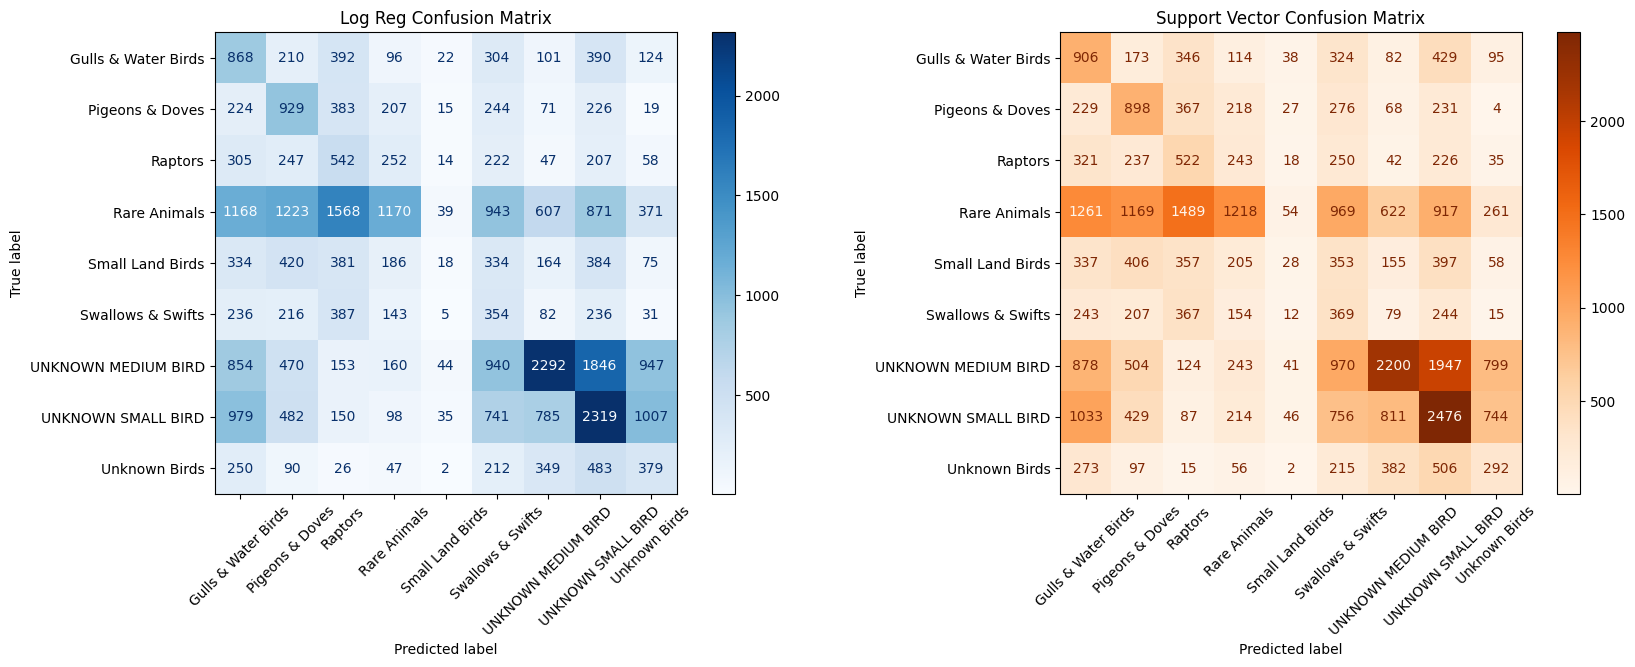

In [312]:
cm_log = confusion_matrix(y_test, y_pred_logr)
cm_sv = confusion_matrix(y_test, y_pred_svc)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ConfusionMatrixDisplay(cm_log, display_labels=log_gr.classes_).plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title('Log Reg Confusion Matrix')

ConfusionMatrixDisplay(cm_sv, display_labels=svc_gr.classes_).plot(ax=axes[1], cmap='Oranges', xticks_rotation=45)
axes[1].set_title('Support Vector Confusion Matrix')

From feeature permutation results below Speed, State_SouthEast and Indident Month appear to be the most influential features. 

<Axes: >

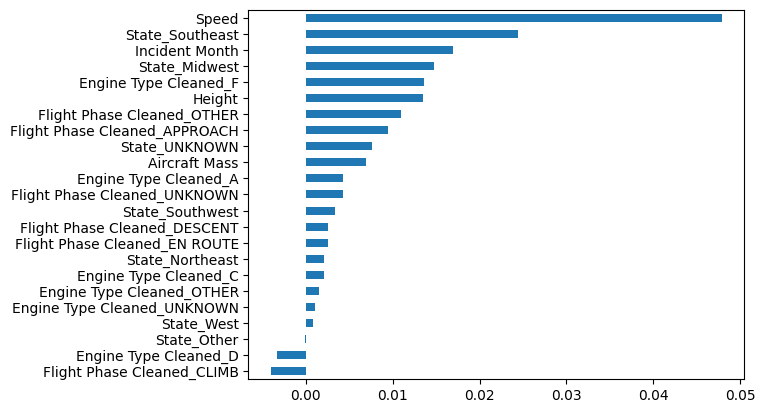

In [313]:
feature_names = tr_enc_df.columns.tolist() + nu_feats  # Combine encoded and numeric features
perm_results = permutation_importance(
    top_svc,
    Xte_sc,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1)

pd.Series(perm_results.importances_mean, index=feature_names).sort_values().plot.barh()

The FINAL MODEL we tried was:
## Random Forest: 
And first we will start with a decision tree... 

In [314]:
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_clf.fit(Xtr_sc, y_tr_bal)

y_pred_tree = tree_clf.predict(Xte_sc)

... then a random forest. 

In [315]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1)
rf_clf.fit(Xtr_sc, y_tr_bal)

y_pred_rf = rf_clf.predict(Xte_sc)

In [316]:
print("Decision Tree CR Results")
print(classification_report(y_test, y_pred_tree))

print("Random Forest CR Results")
print(classification_report(y_test, y_pred_rf))

Decision Tree CR Results
                     precision    recall  f1-score   support

Gulls & Water Birds       0.20      0.35      0.25      2507
    Pigeons & Doves       0.23      0.40      0.29      2318
            Raptors       0.21      0.24      0.22      1894
       Rare Animals       0.54      0.10      0.17      7960
   Small Land Birds       0.15      0.06      0.09      2296
  Swallows & Swifts       0.15      0.37      0.21      1690
UNKNOWN MEDIUM BIRD       0.50      0.46      0.48      7706
 UNKNOWN SMALL BIRD       0.40      0.48      0.44      6596
      Unknown Birds       0.16      0.23      0.19      1838

           accuracy                           0.32     34805
          macro avg       0.28      0.30      0.26     34805
       weighted avg       0.38      0.32      0.30     34805

Random Forest CR Results
                     precision    recall  f1-score   support

Gulls & Water Birds       0.22      0.26      0.23      2507
    Pigeons & Doves       0.25 

In [317]:
ifeat_dt = tree_clf.feature_importances_
impdt_df = pd.DataFrame({"Feature": Xtr_final.columns,
                        "Importance": ifeat_dt}).sort_values(by="Importance", ascending=False)
print("Features of Importance For Decion Tree:")
print(impdt_df)

Features of Importance For Decion Tree:
                          Feature  Importance
15    Engine Type Cleaned_UNKNOWN    0.200909
3                  Incident Month    0.147627
1                          Height    0.144027
2                           Speed    0.116852
20                State_Southwest    0.078862
0                   Aircraft Mass    0.057356
17                State_Northeast    0.050008
9    Flight Phase Cleaned_UNKNOWN    0.044576
19                State_Southeast    0.041500
22                     State_West    0.030705
12          Engine Type Cleaned_D    0.014820
21                  State_UNKNOWN    0.014023
16                  State_Midwest    0.011618
10          Engine Type Cleaned_A    0.010577
8      Flight Phase Cleaned_OTHER    0.009849
4   Flight Phase Cleaned_APPROACH    0.009428
7   Flight Phase Cleaned_EN ROUTE    0.005654
18                    State_Other    0.004249
13          Engine Type Cleaned_F    0.002420
11          Engine Type Cleaned_C    0.0

In [318]:
ifeat_drf = rf_clf.feature_importances_
impdr_df = pd.DataFrame({"Feature": Xtr_final.columns,
                        "Importance": ifeat_drf}).sort_values(by="Importance", ascending=False)
print("Features of Importance For Random Forest:")
print(impdt_df)

Features of Importance For Random Forest:
                          Feature  Importance
15    Engine Type Cleaned_UNKNOWN    0.200909
3                  Incident Month    0.147627
1                          Height    0.144027
2                           Speed    0.116852
20                State_Southwest    0.078862
0                   Aircraft Mass    0.057356
17                State_Northeast    0.050008
9    Flight Phase Cleaned_UNKNOWN    0.044576
19                State_Southeast    0.041500
22                     State_West    0.030705
12          Engine Type Cleaned_D    0.014820
21                  State_UNKNOWN    0.014023
16                  State_Midwest    0.011618
10          Engine Type Cleaned_A    0.010577
8      Flight Phase Cleaned_OTHER    0.009849
4   Flight Phase Cleaned_APPROACH    0.009428
7   Flight Phase Cleaned_EN ROUTE    0.005654
18                    State_Other    0.004249
13          Engine Type Cleaned_F    0.002420
11          Engine Type Cleaned_C    0

Log Loss Scores: 

In [319]:
print(f"Log Loss for Decison Tree: {log_loss(y_test, tree_clf.predict_proba(Xte_sc))}")
print(f"Log Loss for Random Frorest: {log_loss(y_test, rf_clf.predict_proba(Xte_sc))}")

Log Loss for Decison Tree: 1.9184791917666364
Log Loss for Random Frorest: 1.8021593460981502


In [320]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

proba_logr = log_gr.predict_proba(Xte_sc)
proba_dt = tree_clf.predict_proba(Xte_sc)
proba_rf = rf_clf.predict_proba(Xte_sc)

auc_log_macro = roc_auc_score(y_test_bin, proba_logr, average='macro', multi_class='ovr')
auc_log_micro = roc_auc_score(y_test_bin, proba_logr, average='micro', multi_class='ovr')

auc_dt_macro = roc_auc_score(y_test_bin, proba_dt, average='macro', multi_class='ovr')
auc_dt_micro = roc_auc_score(y_test_bin, proba_dt, average='micro', multi_class='ovr')

auc_rf_macro = roc_auc_score(y_test_bin, proba_rf, average='macro', multi_class='ovr')
auc_rf_micro = roc_auc_score(y_test_bin, proba_rf, average='micro', multi_class='ovr')

print(f"Logistic Regression - Macro AUC: {auc_log_macro:.4f}, Micro AUC: {auc_log_micro:.4f}")
print(f"Decision Tree       - Macro AUC: {auc_dt_macro:.4f}, Micro AUC: {auc_dt_micro:.4f}")
print(f"Random Forest       - Macro AUC: {auc_rf_macro:.4f}, Micro AUC: {auc_rf_micro:.4f}")

Logistic Regression - Macro AUC: 0.7093, Micro AUC: 0.7156
Decision Tree       - Macro AUC: 0.7354, Micro AUC: 0.7629
Random Forest       - Macro AUC: 0.7389, Micro AUC: 0.7759


Looking at Macro AUC and micro AUC: 
In first place we have Random Forest that handles class imbalance while maintaining strong overall performance across all classes. This model strikes the best balance between ranking ability and class-wise discrimination while in runner up is the decision tree that outperforms Logistic Regression; it captures nin-linbeararity better by the looks of it. And last is log regression with the lowesst macro scores and its mostly due to its struggle to differenraite between classes. 

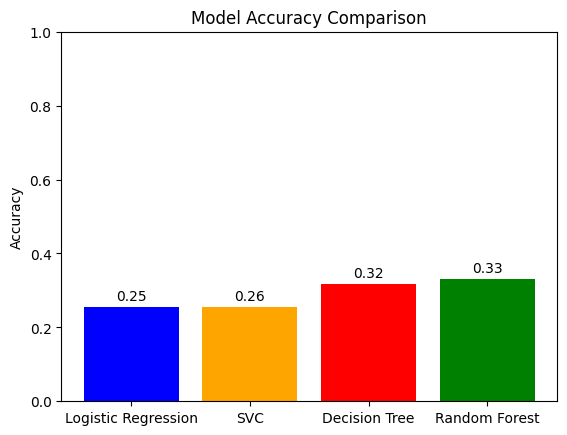

In [321]:
log_accuracy = accuracy_score(y_test, y_pred_logr)
svc_accuracy = accuracy_score(y_test, y_pred_svc)
dt_accuracy = accuracy_score(y_test, y_pred_tree)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
accuracy_scores = [log_accuracy, svc_accuracy, dt_accuracy, rf_accuracy]

model_names = ['Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest']

bars = plt.bar(model_names, accuracy_scores, color=['blue', 'orange', 'red', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')
plt.show()

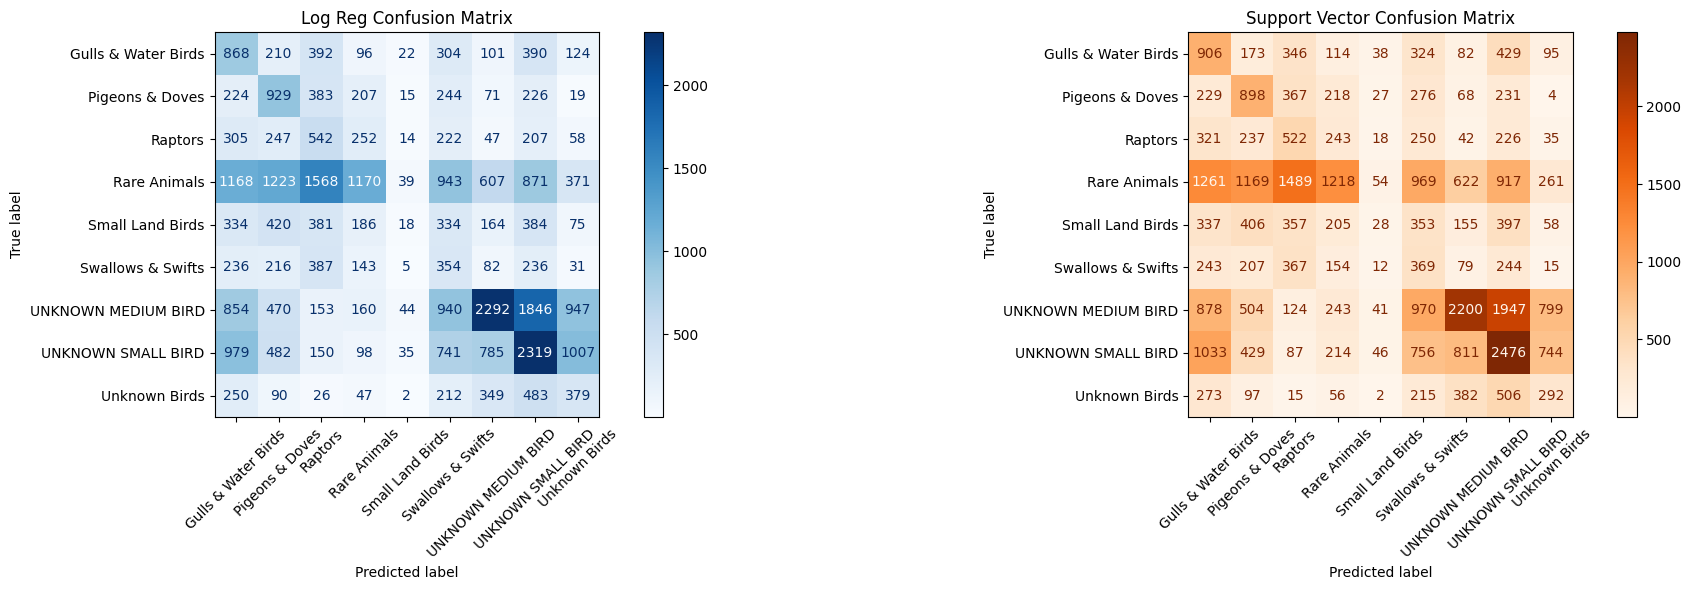

In [322]:
cm_log = confusion_matrix(y_test, y_pred_logr)
cm_sv = confusion_matrix(y_test, y_pred_svc)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ConfusionMatrixDisplay(cm_log, display_labels=log_gr.classes_).plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title('Log Reg Confusion Matrix')

ConfusionMatrixDisplay(cm_sv, display_labels=svc_gr.classes_).plot(ax=axes[1], cmap='Oranges', xticks_rotation=45)
axes[1].set_title('Support Vector Confusion Matrix')

plt.tight_layout()
plt.show()

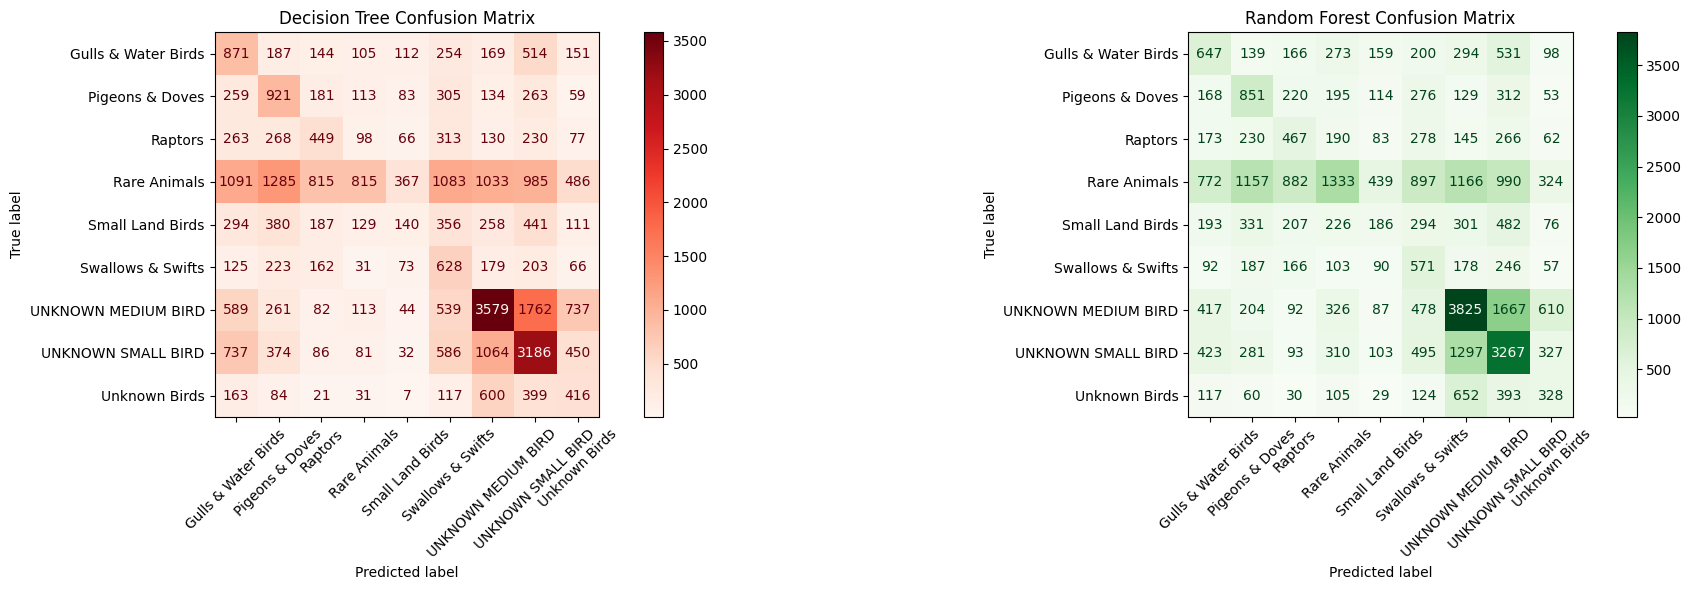

In [323]:
cm_dt = confusion_matrix(y_test, y_pred_tree)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ConfusionMatrixDisplay(cm_dt, display_labels=tree_clf.classes_).plot(ax=axes[0], cmap='Reds', xticks_rotation=45)
axes[0].set_title('Decision Tree Confusion Matrix')

ConfusionMatrixDisplay(cm_rf, display_labels=rf_clf.classes_).plot(ax=axes[1], cmap='Greens', xticks_rotation=45)
axes[1].set_title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

Looking at the confusion matrices across the models, there are a few clear takeaways. Random Forest does the best job handling UNKNOWN classes, with high true positive counts for UNKNOWN MEDIUM BIRD and UNKNOWN SMALL BIRD. In contrast, Logistic Regression struggles significantly with these, often scattering predictions across multiple classes. Rare animals are another challenge—every model misclassifies them frequently, especially into categories like Gulls and Pigeons. This likely points to class imbalance or overlapping features, which might need additional feature engineering or resampling.

Logistic Regression shows the most class confusion overall, with predictions spread too broadly and a lack of clear separations—especially for Gulls & Water Birds. Decision Tree improves on this by separating some UNKNOWN categories better, but it still overfits, mispredicting them in huge numbers. Random Forest helps mitigate this issue by capturing non-linear patterns more effectively, making it the strongest choice for handling these types of classifications.

One consistent trend across models is the high confusion between visually similar bird types, like Swallows & Swifts, Small Land Birds, and Raptors. These misclassifications make sense given real-world similarities in size, flight patterns, and habitat. If interpretability is a priority, grouping certain species or extracting more distinguishing features could improve accuracy. While Random Forest comes out ahead, refining class definitions and balancing dataset representation will be key for future improvements.

OVERALL THE BEST MODELS WHERE (from best to worst) are: 
1. Random Forest -- [main reason: BEST RECALL!]
2. Decision Trees 
3. SVC
4. Log Reg